In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import os
import math
import time
import random
import numpy as np
from collections import deque
from queue import deque
from ChessBoard import ChessBoard

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

##### 定义超参数

In [4]:
EMPTY = 2
# 超参数
GAMMA = 0.9         # Q衰减系数
INITIAL_E = 0.1     # 初始ε
FINAL_E = 0.001		# 初始ε
REPLAY_SIZE = 15000  # 经验回放大小
BATCH_SIZE = 200  	# 批大小
TAGET_Q_STEP = 100  # 目标网络同步训练次数

##### 定义DQN类

In [5]:
class DQN():
    def __init__(self):
        # 棋盘大小
        self.SIZE = ChessBoard.SIZE
        self.state_dim = self.SIZE * self.SIZE
        self.action_dim = self.SIZE * self.SIZE
        # 其它参数
        self.replay_buffer = deque()
        self.time_step = 0
        self.epsilon = INITIAL_E

        # 创建网络
        self.create_Q()
        self.create_targetQ()
        self.targetQ_step = TAGET_Q_STEP
        # 定义优化器
        self.train_method()
        # 定义执行器
        gpu_options = tf.GPUOptions(allow_growth=True)
        gpu_options = tf.GPUOptions(
            per_process_gpu_memory_fraction=0.8, allow_growth=True)  # 每个gpu占用0.8的显存
        config = tf.ConfigProto(
            gpu_options=gpu_options, allow_soft_placement=True, log_device_placement=False)
        # 如果电脑有多个GPU，tensorflow默认全部使用。如果想只使用部分GPU，可以设置CUDA_VISIBLE_DEVICES。
        self.sess = tf.Session(config=config)

        # 网络初始化
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)

    def create_Q(self):
        # 网络权值
        W1 = self.weight_variable([5, 5, 1, 16])
        b1 = self.bias_variable([16])  # 5*5*16
        W2 = self.weight_variable([5*5*16+1, 225])
        b2 = self.bias_variable([1, 225])

        # 输入层
        self.state_input = tf.placeholder("float", [None, self.state_dim])
        self.turn = tf.placeholder("float", [None, 1])

        y0 = tf.reshape(self.state_input, [-1, 15, 15, 1])
        # 第一卷积层
        h1 = tf.nn.relu(self.conv2d(y0, W1) + b1)
        y1 = self.max_pool_3_3(h1)  # 5*5*16

        # 第二全连接层tf.concat([t1, t2], 0)
        h2 = tf.concat([tf.reshape(y1, [-1, 5 * 5 * 16]), self.turn], 1)
        self.Q_value = tf.matmul(h2, W2)+b2
        # 保存权重
        self.Q_weihgts = [W1, b1, W2, b2]

    def create_targetQ(self):
        # 网络权值
        W1 = self.weight_variable([5, 5, 1, 16])
        b1 = self.bias_variable([16])  # 5*5*16
        W2 = self.weight_variable([5*5*16+1, 225])
        b2 = self.bias_variable([1, 225])

        # 输入层
        # self.state_input = tf.placeholder("float", [None, self.state_dim])
        # self.turn = tf.placeholder("float", [None, 1])

        y0 = tf.reshape(self.state_input, [-1, 15, 15, 1])
        # 第一卷积层
        h1 = tf.nn.relu(self.conv2d(y0, W1) + b1)
        y1 = self.max_pool_3_3(h1)  # 5*5*16

        # 第二全连接层tf.concat([t1, t2], 0)
        h2 = tf.concat([tf.reshape(y1, [-1, 5 * 5 * 16]), self.turn], 1)
        self.targetQ_value = tf.matmul(h2, W2)+b2
        # 保存权重
        self.targetQ_weights = [W1, b1, W2, b2]

    def copy(self):
        """拷贝网络"""
        for i in range(len(self.Q_weihgts)):
            self.sess.run(
                tf.assign(self.targetQ_weights[i], self.Q_weihgts[i]))

    def train_method(self):
        self.action_input = tf.placeholder("float", [None, self.action_dim])
        self.y_input = tf.placeholder("float", [None])

        Q_action = tf.reduce_sum(tf.multiply(
            self.Q_value, self.action_input), reduction_indices=1)  # mul->matmul
        self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))
        self.train = tf.train.AdamOptimizer(1e-3).minimize(self.cost)

    def perceive(self, state, action, reward, next_state, done):
        """添加经验池"""
        one_hot_action = np.zeros(self.action_dim)
        one_hot_action[action] = 1
        self.replay_buffer.append(
            [state, one_hot_action, reward, next_state, done])
        # 经验池满了
        if len(self.replay_buffer) > REPLAY_SIZE:
            self.replay_buffer.popleft()
        # 一个batch够了
        if len(self.replay_buffer) > BATCH_SIZE:
            self.train_Q_network()

    def modify_last_reward(self, new_reward):
        v = self.replay_buffer.pop()
        v[2] = new_reward
        self.replay_buffer.append(v)

    def train_Q_network(self):
        self.time_step += 1
        # 构建一个小的训练batch
        minibatch = random.sample(self.replay_buffer, BATCH_SIZE)
        state_batch = [data[0][0] for data in minibatch]
        state_batch_turn = [data[0][1] for data in minibatch]
        action_batch = [data[1] for data in minibatch]
        reward_batch = [data[2] for data in minibatch]
        next_state_batch = [data[3][0] for data in minibatch]
        next_state_batch_turn = [data[3][1] for data in minibatch]
        # 构建训练数据
        y_batch = []

        """
            这里是计算新局面的估值                                                                                                                    Q'
            使用：targetQ 或 Q  网络来计算

            全局就在此处可能使用targetQ，作为对新状态的估值
        """
        # 计算Q'的所有值

        # Q_value_batch = self.sess.run(self.Q_value, feed_dict={
        #    self.state_input: next_state_batch, self.turn: next_state_batch_turn})
        Q_value_batch = self.sess.run(self.targetQ_value, feed_dict={
            self.state_input: next_state_batch, self.turn: next_state_batch_turn})

        # Q的值 Q = γ * max(Q')
        for i in range(0, BATCH_SIZE):
            done = minibatch[i][4]  # 是否结束
            if done:
                y_batch.append(reward_batch[i])
            else:
                y_batch.append(reward_batch[i] +
                               GAMMA * np.max(Q_value_batch[i]))
        self.sess.run(self.train, feed_dict={
                      self.y_input: y_batch, self.action_input: action_batch, self.state_input: state_batch, self.turn: state_batch_turn})

        # 每一定轮次 拷贝Q网络到targetQ网络
        if self.time_step % self.targetQ_step == 0:
            self.copy()

    def egreedy_action(self, state):
        """含有随机 计算一步"""
        # 计算当前局面的所有Q值
        Q_value = self.sess.run(self.Q_value, feed_dict={
                                self.state_input: [state[0]], self.turn: [state[1]]})[0]

        min_v = Q_value[np.argmin(Q_value)] - 1  # 最小的Q_value -1
        valid_action = []

        for i in range(len(Q_value)):  # 遍历每一个落子点
            if state[0][i] == EMPTY:  # 空，可以落子
                valid_action.append(i)
            else:  # 有棋子，不可以落子
                Q_value[i] = min_v

        # 以 epsilon的概率随机落子
        if random.random() <= self.epsilon:
            l = len(valid_action)
            if l == 0:
                return -1
            else:
                return valid_action[random.randint(0, len(valid_action) - 1)]
        else:  # 其它清空，选取Q最大的点落子
            return np.argmax(Q_value)

    def action(self, state):
       # 计算当前局面的所有Q值
        Q_value = self.sess.run(self.Q_value, feed_dict={
            self.state_input: [state[0]], self.turn: [state[1]]})[0]

        min_v = Q_value[np.argmin(Q_value)] - 1  # 最小的Q_value -1
        valid_action = []

        for i in range(len(Q_value)):  # 遍历每一个落子点
            if state[0][i] == EMPTY:  # 空，可以落子
                valid_action.append(i)
            else:  # 有棋子，不可以落子
                Q_value[i] = min_v
        return np.argmax(Q_value)

    def weight_variable(self, shape):
        initial = tf.truncated_normal(shape)
        return tf.Variable(initial)

    def bias_variable(self, shape):
        initial = tf.constant(0.01, shape=shape)
        return tf.Variable(initial)

    def conv2d(self, x, w):
        """定义卷积函数"""
        return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_3_3(self, x):
        """定义2*2最大池化层"""
        return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='SAME')


In [6]:
def test():
    total_reward = 0
    # 初始一个棋盘
    chess = ChessBoard()  # 创建一个主棋盘
    chess.reset()
    
    state = chess.board
    camp = np.zeros([1])
    camp[0] = -1
    state = np.reshape(state, [-1])
    state = [state, camp]
    
    for j in range(225):
        # 开始走棋
        action = agent.action(state)  # 按照Q网络的走一步
        action = [math.floor(action/ChessBoard.SIZE), action %
                  ChessBoard.SIZE, camp]  # 转化为二维棋盘坐标

        state, reward, done, _ = chess.draw_XY(action[0], action[1])
        state = np.reshape(state, [-1])
        
        if j % 2 == 0:
            camp[0] = 1
        else:
            camp[0] = -1
        state = [state, camp]
        total_reward += reward

        # 打印棋盘
        os.system("cls")
        chess.printChess()
        if camp == 1:
            print(" BLACK %d   %d\n" % (action[0], action[1]))
        else:
            print(" WHITE %d   %d\n" % (action[0], action[1]))
        time.sleep(2)  # 睡眠延时

        # 结束判断
        if done:
            print("done step:%d  episode:%d" % (j, episode))
            # print('done')
            time.sleep(5)
            break
    ave_reward = total_reward
    print('episode: ', episode, 'Evaluation Average Reward:', ave_reward)

In [7]:
train_step = []
agent = DQN()  # 创建网络对象
agent.copy()  # 拷贝Q网络参数到targetQ

In [8]:
def main():
    # 一些超参数
    EPISODE = 10000
    STEP = 300
    TEST = 1

    chess = ChessBoard()  # 创建一个主棋盘

    for episode in range(EPISODE):
        # 初始一个棋盘
        chess.reset()
        state = chess.board
        camp = np.zeros([1])
        camp[0] = -1
        state = np.reshape(state, [-1])  # 二维数组转换为一维数组
        state = [state, camp]
        
        if episode%100==99 and agent.epsilon>FINAL_E:
            agent.epsilon *= 0.99  # 每100局，减小随机选择落子点的概率
            
        # 训练
        for step in range(STEP):
            # 自己下一步棋
            action_1d = agent.egreedy_action(state)  # 有随机概率的走一步
            action_2d = [math.floor(action_1d / ChessBoard.SIZE), action_1d %
                         ChessBoard.SIZE, camp]  # 转化为二维棋盘坐标
            # 在模拟棋盘上落子
            next_state_2d, reward, done, _ = chess.draw_XY(
                action_2d[0], action_2d[1])
            next_state = np.reshape(next_state_2d, [-1])
            # 构造数据
            if step % 2 == 0:
                camp[0] = 1
            else:
                camp[0] = -1
            next_state = [next_state, camp]
            # 定义奖励
            reward_agent = reward
            # 丢入经验池  执行训练
            agent.perceive(state, action_1d, reward, next_state, done)
            state = next_state
            # 判断这一步走了每    没走说明这一步是非法的，发生了碰撞，立即结束当前棋局，重开一局
            # 上面的判断不是很对
            # 成功落子后反而跳出了
            if done:
                #chess.printChess()
                train_step.append(step)
                print("done step:%d  episode:%d epsilon:%.5f" % (step, episode,agent.epsilon))
                break  


##### 开始训练

In [18]:
time_start = time.time()
for z in range(3):
    main()
time_end = time.time()

done step:49  episode:0 epsilon:0.06173
done step:65  episode:1 epsilon:0.06173
done step:29  episode:2 epsilon:0.06173
done step:39  episode:3 epsilon:0.06173
done step:25  episode:4 epsilon:0.06173
done step:38  episode:5 epsilon:0.06173
done step:37  episode:6 epsilon:0.06173
done step:28  episode:7 epsilon:0.06173
done step:40  episode:8 epsilon:0.06173
done step:57  episode:9 epsilon:0.06173
done step:44  episode:10 epsilon:0.06173
done step:38  episode:11 epsilon:0.06173
done step:37  episode:12 epsilon:0.06173
done step:127  episode:13 epsilon:0.06173
done step:107  episode:14 epsilon:0.06173
done step:21  episode:15 epsilon:0.06173
done step:25  episode:16 epsilon:0.06173
done step:115  episode:17 epsilon:0.06173
done step:21  episode:18 epsilon:0.06173
done step:35  episode:19 epsilon:0.06173
done step:29  episode:20 epsilon:0.06173
done step:106  episode:21 epsilon:0.06173
done step:21  episode:22 epsilon:0.06173
done step:33  episode:23 epsilon:0.06173
done step:34  episode:

done step:11  episode:198 epsilon:0.06111
done step:13  episode:199 epsilon:0.06050
done step:10  episode:200 epsilon:0.06050
done step:8  episode:201 epsilon:0.06050
done step:15  episode:202 epsilon:0.06050
done step:12  episode:203 epsilon:0.06050
done step:15  episode:204 epsilon:0.06050
done step:8  episode:205 epsilon:0.06050
done step:10  episode:206 epsilon:0.06050
done step:10  episode:207 epsilon:0.06050
done step:11  episode:208 epsilon:0.06050
done step:9  episode:209 epsilon:0.06050
done step:13  episode:210 epsilon:0.06050
done step:10  episode:211 epsilon:0.06050
done step:11  episode:212 epsilon:0.06050
done step:10  episode:213 epsilon:0.06050
done step:10  episode:214 epsilon:0.06050
done step:15  episode:215 epsilon:0.06050
done step:8  episode:216 epsilon:0.06050
done step:11  episode:217 epsilon:0.06050
done step:22  episode:218 epsilon:0.06050
done step:10  episode:219 epsilon:0.06050
done step:8  episode:220 epsilon:0.06050
done step:8  episode:221 epsilon:0.0605

done step:97  episode:394 epsilon:0.05990
done step:12  episode:395 epsilon:0.05990
done step:15  episode:396 epsilon:0.05990
done step:14  episode:397 epsilon:0.05990
done step:14  episode:398 epsilon:0.05990
done step:17  episode:399 epsilon:0.05930
done step:14  episode:400 epsilon:0.05930
done step:15  episode:401 epsilon:0.05930
done step:10  episode:402 epsilon:0.05930
done step:10  episode:403 epsilon:0.05930
done step:10  episode:404 epsilon:0.05930
done step:8  episode:405 epsilon:0.05930
done step:12  episode:406 epsilon:0.05930
done step:15  episode:407 epsilon:0.05930
done step:11  episode:408 epsilon:0.05930
done step:11  episode:409 epsilon:0.05930
done step:13  episode:410 epsilon:0.05930
done step:15  episode:411 epsilon:0.05930
done step:13  episode:412 epsilon:0.05930
done step:9  episode:413 epsilon:0.05930
done step:9  episode:414 epsilon:0.05930
done step:10  episode:415 epsilon:0.05930
done step:13  episode:416 epsilon:0.05930
done step:13  episode:417 epsilon:0.0

done step:31  episode:590 epsilon:0.05870
done step:16  episode:591 epsilon:0.05870
done step:10  episode:592 epsilon:0.05870
done step:10  episode:593 epsilon:0.05870
done step:19  episode:594 epsilon:0.05870
done step:41  episode:595 epsilon:0.05870
done step:25  episode:596 epsilon:0.05870
done step:19  episode:597 epsilon:0.05870
done step:21  episode:598 epsilon:0.05870
done step:23  episode:599 epsilon:0.05812
done step:14  episode:600 epsilon:0.05812
done step:12  episode:601 epsilon:0.05812
done step:26  episode:602 epsilon:0.05812
done step:8  episode:603 epsilon:0.05812
done step:11  episode:604 epsilon:0.05812
done step:24  episode:605 epsilon:0.05812
done step:10  episode:606 epsilon:0.05812
done step:31  episode:607 epsilon:0.05812
done step:14  episode:608 epsilon:0.05812
done step:13  episode:609 epsilon:0.05812
done step:13  episode:610 epsilon:0.05812
done step:41  episode:611 epsilon:0.05812
done step:11  episode:612 epsilon:0.05812
done step:16  episode:613 epsilon:0

KeyboardInterrupt: 

In [19]:
print(len(train_step))
test()

5505
    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 3  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 4  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 5  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 6  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 7  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 8  -  -  -  -  -  -  -  -  *  -  -  -  -  -  -
 9  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
10  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
11  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
12  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
13  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
14  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 BLACK 8   8

    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 3  -  -  -  -  -  - 

    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 3  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 4  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 5  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 6  -  -  -  -  -  -  o  -  -  -  -  -  -  -  -
 7  -  -  -  -  -  -  *  -  -  -  -  -  -  -  -
 8  -  -  -  -  -  -  *  *  *  -  -  -  -  -  -
 9  -  -  -  -  -  -  o  -  -  o  -  -  -  -  -
10  -  -  -  -  -  -  *  -  -  -  o  -  -  -  -
11  -  -  -  -  -  -  *  -  -  -  o  o  -  -  -
12  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
13  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
14  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 WHITE 11   11

    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 3  -  -  -  -  -  -  - 

    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 3  -  -  -  *  -  -  -  -  -  -  -  -  -  -  -
 4  -  -  -  -  *  -  -  -  -  -  -  -  -  -  -
 5  -  -  -  -  -  o  -  -  -  -  -  -  -  -  -
 6  -  -  -  -  -  -  o  -  o  -  -  -  -  -  -
 7  -  -  -  -  -  -  *  o  -  -  *  *  -  -  -
 8  -  -  -  -  -  -  *  *  *  -  -  -  -  -  -
 9  -  -  -  -  -  -  o  -  -  o  -  -  -  -  -
10  -  -  -  -  -  -  *  -  -  *  o  -  -  o  -
11  -  -  -  -  -  -  *  -  -  -  o  o  -  -  -
12  -  -  -  -  -  -  *  -  -  o  -  -  -  -  -
13  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
14  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 BLACK 7   10

    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 1  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 2  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
 3  -  -  -  *  -  -  -  

KeyboardInterrupt: 

In [13]:
print(len(train_step))

20059


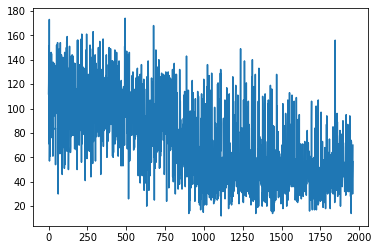

In [13]:
plt.plot(train_step[0:10000])
#plt.savefig("C:/Users/王欣哲/Desktop/codes/人工智能基础/问题4 监督学习/15-15_前10000step图.jpg")
plt.show()